In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pickle

## preprocess

In [18]:
campaign = pd.read_json('campaign_impressions.json', lines=True, orient='columns')

In [19]:
segments = pd.read_csv('user_segments.csv')

In [20]:
segments.rename(columns = {'Unnamed: 0':'uuid'}, inplace = True)

In [21]:
for i in ['resp', 'dev']:
    column_unnested = pd.json_normalize(campaign[i])
    column_unnested = column_unnested.add_prefix(i+'_')
    campaign = campaign.drop([i], axis = 1)
    campaign = pd.concat([campaign, column_unnested], axis=1)

In [22]:
campaign_enriched = pd.merge(campaign,segments,how='right',
                             
                             left_on=['uuid'],right_on=['uuid'])

In [55]:
campaign_enriched["ts"] = pd.to_datetime(campaign_enriched.ts, unit='s')
campaign_enriched['hour'] = campaign_enriched.ts.dt.hour 
campaign_enriched["hour_sin"] = campaign_enriched['hour'].apply(lambda x: np.sin(x / 24 * 2 * np.pi))
campaign_enriched["hour_cos"] = campaign_enriched['hour'].apply(lambda x: np.cos(x / 24 * 2 * np.pi))

In [24]:
# loop to change each column to category type

categorical_cols = ['conv', 'resp_oi', 'resp_cr', 'resp_c', 'dev_os', 'dev_sid', 'dev_app']
for col in categorical_cols:
    campaign_enriched[col] = campaign_enriched[col].astype('category',copy=False)

## hyperparameters tuning

In [29]:
X = campaign_enriched[['resp_c', 'hour', 'dev_app', 'dev_sid', 'dev_os', 'OFFICE_WORKER', 'PARENT', 
                       'hour_sin', 'hour_cos']]
y =  campaign_enriched[['conv']]

In [ ]:
RANDOM_SEED = 42

# 20-fold CV
kfolds = StratifiedKFold(n_splits=20, shuffle=True, random_state=RANDOM_SEED)

def tune(objective):
    
    """ Defining the helper function so that it can be reused """
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

In [30]:
def randomforest_objective(trial):
    _max_depth = trial.suggest_int("max_depth", 3, 6)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)

    rf = RandomForestClassifier(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        n_estimators=2000,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )

    scores = cross_val_score(
        rf, X, y.values.ravel(), cv=kfolds, scoring="f1"
    )
    return scores.mean()

In [31]:
randomforest_params = tune(randomforest_objective)

[I 2023-01-09 00:24:46,784] A new study created in memory with name: no-name-063c51f3-64e1-468a-a801-62dc5ac6efb5
[I 2023-01-09 00:25:32,080] Trial 0 finished with value: 0.29920422685831627 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.29920422685831627.
[I 2023-01-09 00:26:11,768] Trial 1 finished with value: 0.2342594059022194 and parameters: {'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.29920422685831627.
[I 2023-01-09 00:26:53,567] Trial 2 finished with value: 0.2991460211471605 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.29920422685831627.
[I 2023-01-09 00:27:35,161] Trial 3 finished with value: 0.30051941257067233 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.30051941257067233.
[I 2023-01-09 00:28:13,324] Trial 4 finished with value: 0.

Best score: 0.3014036751225111

Optimized parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}



## testing the model

In [32]:
rf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED, **randomforest_params)

In [33]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

scoring = {'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

results = cross_validate(rf, X, y.values.ravel(), cv=kfolds, scoring=scoring, return_train_score=True)

In [58]:
def plot_results_scoring(score):
    
    """ plotting results of scoring """
    for key, data_list in results.items():
        label_to_print = str(key)
        if score in label_to_print:
            plt.plot(data_list,label=label_to_print)

    plt.legend(loc='upper right', borderaxespad=0, bbox_to_anchor=(1.5, 1.05))

    plt.show()

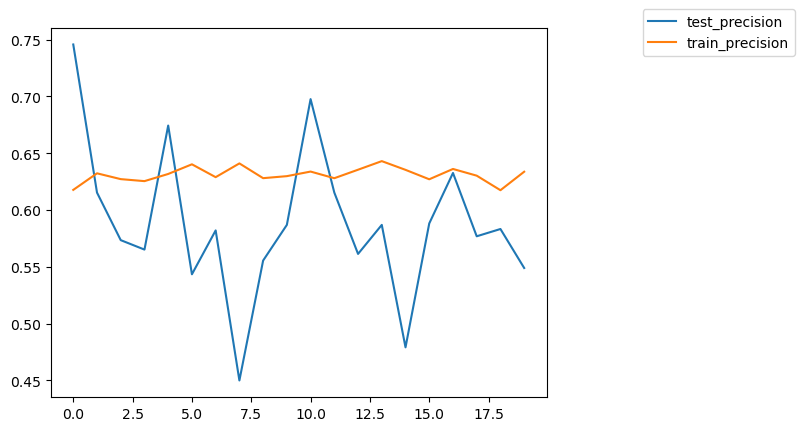

In [59]:
plot_results_scoring('precision')

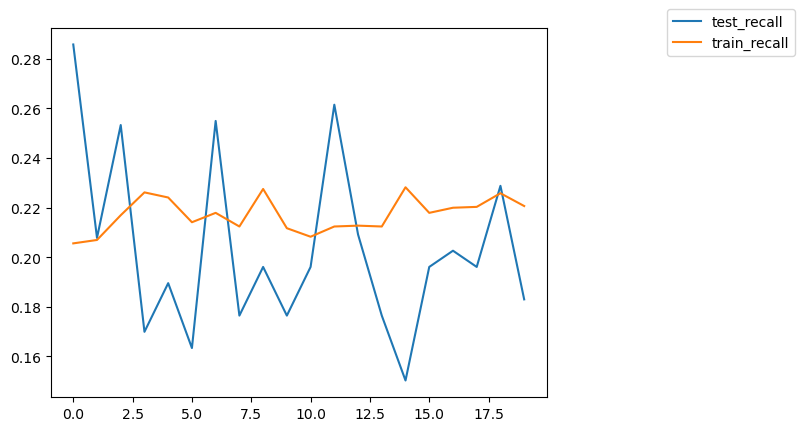

In [60]:
plot_results_scoring('recall')

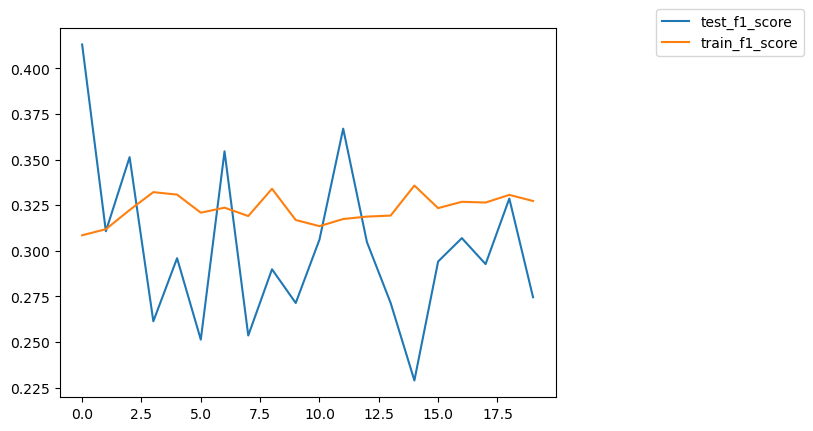

In [40]:
plot_results_scoring('f1')

## modele stocké en pickle 

In [50]:
# split test train

X_train = X.iloc[:-1 , :]
y_train = y.iloc[:-1 , :].values.ravel()
X_test = X.tail(1)

In [44]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=5, min_samples_split=4,
                       n_jobs=-1, random_state=42)

In [46]:
pickle.dump(rf, open('model.pkl','wb'))

In [53]:
X_test.to_json('test', orient="records")